## run_wan_vae_in_post.ipynb

In [1]:
# !pip install matplotlib

In [1]:
# Copyright 2024-2025 The Alibaba Wan Team Authors. All rights reserved.
import argparse
from datetime import datetime
import logging
import os
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

import torch, random
import torch.distributed as dist
from PIL import Image

# sys.path.append('/workspace/Wan2.1')
sys.path.append('/home/stephen/sora/Wan2.1')
import wan
from wan.configs import WAN_CONFIGS, SIZE_CONFIGS, MAX_AREA_CONFIGS, SUPPORTED_SIZES
from wan.utils.prompt_extend import DashScopePromptExpander, QwenPromptExpander
from wan.utils.utils import cache_video, cache_image, str2bool
from wan.modules.vae import WanVAE

In [2]:
checkpoint_dir='/home/stephen/sora/Wan2.1/Wan2.1-T2V-14B'
device='cpu'

vae = WanVAE(
    vae_pth=os.path.join(checkpoint_dir, 'Wan2.1_VAE.pth'),
    device=device)

In [3]:
data_dir='/home/stephen/sora/jul_15/july_15_1/'
fn='all_x0_20250715_165403.pt.'
all_x0=torch.load(data_dir+fn)

In [4]:
len(all_x0)

51

In [5]:
all_x0[0].shape

torch.Size([16, 21, 90, 160])

In [ ]:
videos=vae.decode(all_x0[-1].to(device))

In [ ]:
from wan.utils.utils import cache_image, cache_video, str2bool

In [ ]:
cache_video(
    tensor=videos[0],
    save_file='/home/stephen/sora/jul_15/'+fn.split('.')[0]+'_x50.mp4',
    fps=16,
    nrow=1,
    normalize=True,
    value_range=(-1, 1))

---

In [5]:
def sinusoidal_embedding_1d(dim, position):
    # preprocess
    assert dim % 2 == 0
    half = dim // 2
    position = position.type(torch.float64)

    # calculation
    sinusoid = torch.outer(
        position, torch.pow(10000, -torch.arange(half).to(position).div(half)))
    x = torch.cat([torch.cos(sinusoid), torch.sin(sinusoid)], dim=1)
    return x

In [6]:
def _validate_args(args):
    # Basic check
    assert args.ckpt_dir is not None, "Please specify the checkpoint directory."
    assert args.task in WAN_CONFIGS, f"Unsupport task: {args.task}"
    assert args.task in EXAMPLE_PROMPT, f"Unsupport task: {args.task}"

    # The default sampling steps are 40 for image-to-video tasks and 50 for text-to-video tasks.
    if args.sample_steps is None:
        args.sample_steps = 40 if "i2v" in args.task else 50

    if args.sample_shift is None:
        args.sample_shift = 5.0
        if "i2v" in args.task and args.size in ["832*480", "480*832"]:
            args.sample_shift = 3.0

    # The default number of frames are 1 for text-to-image tasks and 81 for other tasks.
    if args.frame_num is None:
        args.frame_num = 1 if "t2i" in args.task else 81

    # T2I frame_num check
    if "t2i" in args.task:
        assert args.frame_num == 1, f"Unsupport frame_num {args.frame_num} for task {args.task}"

    args.base_seed = args.base_seed if args.base_seed >= 0 else random.randint(
        0, sys.maxsize)
    # Size check
    assert args.size in SUPPORTED_SIZES[
        args.
        task], f"Unsupport size {args.size} for task {args.task}, supported sizes are: {', '.join(SUPPORTED_SIZES[args.task])}"

In [8]:
# Set up default arguments as variables for easy modification
task = "t2v-14B"
size = "1280*720"
frame_num = None
# ckpt_dir = './Wan2.1-T2V-14'
ckpt_dir= '/workspace/Wan2.1/Wan2.1-T2V-14B'
offload_model = True
ulysses_size = 1
ring_size = 1
t5_fsdp = False
t5_cpu = True
dit_fsdp = False
save_file = None
prompt = "An astronaut riding a horse on the Moon"
use_prompt_extend = False
prompt_extend_method = "local_qwen"
prompt_extend_model = None
prompt_extend_target_lang = "zh"
base_seed = -1
image = None
sample_solver = "unipc"
sample_steps = None
sample_shift = 8
sample_guide_scale = 6.0

# Create args object as a SimpleNamespace (similar to argparse.Namespace)
from types import SimpleNamespace
args = SimpleNamespace(
    task=task, size=size, frame_num=frame_num, ckpt_dir=ckpt_dir, offload_model=offload_model,
    ulysses_size=ulysses_size, ring_size=ring_size, t5_fsdp=t5_fsdp, t5_cpu=t5_cpu, 
    dit_fsdp=dit_fsdp, save_file=save_file, prompt=prompt, use_prompt_extend=use_prompt_extend,
    prompt_extend_method=prompt_extend_method, prompt_extend_model=prompt_extend_model,
    prompt_extend_target_lang=prompt_extend_target_lang, base_seed=base_seed, image=image,
    sample_solver=sample_solver, sample_steps=sample_steps, sample_shift=sample_shift,
    sample_guide_scale=sample_guide_scale
)

# Optional: Validate args (you can uncomment and modify as needed)
# def validate_args(args):
#     # Add validation logic here
#     pass
# validate_args(args)

In [9]:
_validate_args(args)

In [10]:
args.task

't2v-14B'

In [11]:
# def generate(args):
rank = int(os.getenv("RANK", 0))
world_size = int(os.getenv("WORLD_SIZE", 1))
local_rank = int(os.getenv("LOCAL_RANK", 0))
device = local_rank

In [12]:
device, world_size, local_rank, rank

(0, 1, 0, 0)

In [13]:
cfg = WAN_CONFIGS[args.task]

In [14]:
cfg

{'__name__': 'Config: Wan T2V 14B',
 't5_model': 'umt5_xxl',
 't5_dtype': torch.bfloat16,
 'text_len': 512,
 'param_dtype': torch.bfloat16,
 'num_train_timesteps': 1000,
 'sample_fps': 16,
 'sample_neg_prompt': '色调艳丽，过曝，静态，细节模糊不清，字幕，风格，作品，画作，画面，静止，整体发灰，最差质量，低质量，JPEG压缩残留，丑陋的，残缺的，多余的手指，画得不好的手部，画得不好的脸部，畸形的，毁容的，形态畸形的肢体，手指融合，静止不动的画面，杂乱的背景，三条腿，背景人很多，倒着走',
 't5_checkpoint': 'models_t5_umt5-xxl-enc-bf16.pth',
 't5_tokenizer': 'google/umt5-xxl',
 'vae_checkpoint': 'Wan2.1_VAE.pth',
 'vae_stride': (4, 8, 8),
 'patch_size': (1, 2, 2),
 'dim': 5120,
 'ffn_dim': 13824,
 'freq_dim': 256,
 'num_heads': 40,
 'num_layers': 40,
 'window_size': (-1, -1),
 'qk_norm': True,
 'cross_attn_norm': True,
 'eps': 1e-06}

In [15]:
args.ulysses_size

1

In [16]:
dist.is_initialized()

False

In [ ]:
#This is probably one to break apart. 
wan_t2v = wan.WanT2V(
    config=cfg,
    checkpoint_dir=args.ckpt_dir,
    device_id=device,
    rank=rank,
    t5_fsdp=args.t5_fsdp,
    dit_fsdp=args.dit_fsdp,
    use_usp=(args.ulysses_size > 1 or args.ring_size > 1),
    t5_cpu=args.t5_cpu,
)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

### Let's get inside the wan class here

```
video = wan_t2v.generate(
    args.prompt,
    size=SIZE_CONFIGS[args.size],
    frame_num=args.frame_num,
    shift=args.sample_shift,
    sample_solver=args.sample_solver,
    sampling_steps=args.sample_steps,
    guide_scale=args.sample_guide_scale,
    seed=args.base_seed,
    offload_model=args.offload_model)
```


In [ ]:
import gc
import logging
import math
import os
import random
import sys
import types
from contextlib import contextmanager
from functools import partial

import torch
import torch.cuda.amp as amp
import torch.distributed as dist
from tqdm import tqdm

# from .distributed.fsdp import shard_model
sys.path.append('/workspace/Wan2.1/wan')
from modules.model import WanModel
from modules.t5 import T5EncoderModel
from modules.vae import WanVAE
from utils.fm_solvers import (FlowDPMSolverMultistepScheduler,
                               get_sampling_sigmas, retrieve_timesteps)
from utils.fm_solvers_unipc import FlowUniPCMultistepScheduler

In [ ]:
input_prompt=args.prompt
size=SIZE_CONFIGS[args.size]
frame_num=args.frame_num
shift=args.sample_shift
sample_solver=args.sample_solver
sampling_steps=args.sample_steps
guide_scale=args.sample_guide_scale
n_prompt=""
seed=args.base_seed
offload_model=args.offload_model

In [ ]:
F = frame_num

In [ ]:
F

In [ ]:
target_shape = (wan_t2v.vae.model.z_dim, (F - 1) // wan_t2v.vae_stride[0] + 1,
                size[1] // wan_t2v.vae_stride[1],
                size[0] // wan_t2v.vae_stride[2])

In [ ]:
target_shape #Like...chanels, time, height, width?

In [ ]:
seq_len = math.ceil((target_shape[2] * target_shape[3]) /
                    (wan_t2v.patch_size[1] * wan_t2v.patch_size[2]) *
                    target_shape[1] / wan_t2v.sp_size) * wan_t2v.sp_size

In [ ]:
seq_len #Hmm something unrolled here?

In [ ]:
n_prompt

In [37]:
#Ok yeah bet this as applied in my diffusers test!! Good find. 
#Comment out after validating that run works. 
if n_prompt == "":
    n_prompt = wan_t2v.sample_neg_prompt

In [38]:
n_prompt

'色调艳丽，过曝，静态，细节模糊不清，字幕，风格，作品，画作，画面，静止，整体发灰，最差质量，低质量，JPEG压缩残留，丑陋的，残缺的，多余的手指，画得不好的手部，画得不好的脸部，畸形的，毁容的，形态畸形的肢体，手指融合，静止不动的画面，杂乱的背景，三条腿，背景人很多，倒着走'

'Gorgeous colors, overexposed, static, blurred details, subtitles, style, artwork, painting, picture, still, overall gray, worst quality, low quality, JPEG compression residue, ugly, incomplete, extra fingers, poorly drawn hands, poorly drawn faces, deformed, disfigured, deformed limbs, fused fingers, still picture, cluttered background, three legs, many people in the background, walking backwards

In [39]:
seed = seed if seed >= 0 else random.randint(0, sys.maxsize)

In [40]:
seed

6148191673278419463

In [41]:
seed_g = torch.Generator(device=wan_t2v.device)

In [42]:
seed_g.manual_seed(seed)

In [43]:
seed_g

In [44]:
wan_t2v.t5_cpu

True

In [45]:
context = wan_t2v.text_encoder([input_prompt], torch.device('cpu')) #Damn this is slow -> i guess it is on CPU!

In [46]:
context

[tensor([[ 1.9836e-03,  3.1738e-02, -1.6602e-02,  ...,  1.5163e-04,
           2.0386e-02, -1.7944e-02],
         [ 1.5869e-03,  2.2705e-02, -1.0449e-01,  ..., -1.1253e-04,
          -1.0498e-01,  3.6865e-02],
         [ 1.9150e-03,  3.4332e-04,  1.0791e-01,  ..., -9.4604e-04,
          -1.5625e-01,  4.6875e-02],
         ...,
         [ 2.1515e-03,  8.4473e-02,  1.0889e-01,  ..., -3.1471e-04,
           7.0801e-02,  8.8501e-03],
         [ 1.8234e-03, -3.8330e-02,  7.4158e-03,  ...,  3.2806e-04,
           3.5400e-02, -3.8452e-03],
         [-5.7220e-04, -3.3417e-03,  2.2736e-03,  ...,  3.7193e-04,
          -7.1411e-03,  3.6011e-03]], dtype=torch.bfloat16)]

In [47]:
len(context)

1

In [48]:
context[0].shape

torch.Size([28, 4096])

In [49]:
input_prompt

'Two anthropomorphic cats in comfy boxing gear and bright gloves fight intensely on a spotlighted stage.'

Ok cool -> the prompt must be 28 tokens. 

In [50]:
context_null = wan_t2v.text_encoder([n_prompt], torch.device('cpu'))

In [51]:
context_null[0].shape

torch.Size([126, 4096])

In [52]:
context = [t.to(wan_t2v.device) for t in context] #Just shipping to device, got it. 
context_null = [t.to(wan_t2v.device) for t in context_null]

In [53]:
wan_t2v.device

device(type='cuda', index=0)

In [54]:
#Ah man I love this!
noise = [
    torch.randn(
        target_shape[0],
        target_shape[1],
        target_shape[2],
        target_shape[3],
        dtype=torch.float32,
        device=wan_t2v.device,
        generator=seed_g)
]

In [55]:
len(noise)

1

In [56]:
noise[0].shape

torch.Size([16, 21, 90, 160])

In [57]:
sample_solver

'unipc'

```
    def forward(
        self,
        x,
        t,
        context,
        seq_len,
        clip_fea=None,
        y=None,
```


In [58]:
@contextmanager
def noop_no_sync():
    yield

no_sync = getattr(wan_t2v.model, 'no_sync', noop_no_sync)

# evaluation mode
with amp.autocast(dtype=wan_t2v.param_dtype), torch.no_grad(), no_sync():
    sample_scheduler = FlowUniPCMultistepScheduler(
                    num_train_timesteps=wan_t2v.num_train_timesteps,
                    shift=1,
                    use_dynamic_shifting=False)
    sample_scheduler.set_timesteps(
        sampling_steps, device=wan_t2v.device, shift=shift)
    timesteps = sample_scheduler.timesteps

    latents = noise #Fun line

    arg_c = {'context': context, 'seq_len': seq_len}
    arg_null = {'context': context_null, 'seq_len': seq_len}

    for _, t in enumerate(tqdm(timesteps)): #timesteps[:2])): #timesteps)): #Ok i think with was the problem!
        latent_model_input = latents
        timestep = [t]
    
        timestep = torch.stack(timestep)
    
        wan_t2v.model.to(wan_t2v.device)
        # noise_pred_cond = wan_t2v.model(
        #     latent_model_input, t=timestep, **arg_c)[0]

        ## --- Break into model forward pass here --- ## 
        x=latent_model_input
        t=timestep
        context=arg_c['context']
        seq_len=arg_c['seq_len']

        # embeddings
        # Ok in this first step we go from torch.Size([16, 21, 60, 104]) to [1, 1536, 21, 30, 52])
        # Ok cool yeah this makes a lot of sense, very similiar to what CogVideoX folks did
        # This is Conv3d layer. 2 by 2 by 16 patches go to 1536 length vectors
        # are they touching the time dimension at all here? No? 
        # wan_t2v.model.patch_embedding
        # Conv3d(16, 1536, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        # wan_t2v.model.patch_embedding.weight.shape
        # torch.Size([1536, 16, 1, 2, 2])
        # yeah so I think that temporal stride of 1 means no. 
        
        viz['x_initial_'+str(_)]=create_image_grid(x[0].detach().clone().float().cpu())
        
        x = [wan_t2v.model.patch_embedding(u.unsqueeze(0)) for u in x] #torch.Size([1, 1536, 21, 30, 52])

        viz['x_patchified_'+str(_)]=x[0].detach().clone().float().cpu()

        grid_sizes = torch.stack(
            [torch.tensor(u.shape[2:], dtype=torch.long) for u in x]) #tensor([[21, 30, 52]])

        # Ok pretty sure this one is unrolling time, height, and width. So it's kinda like 1536 features each of the full 
        # compressed video size. It's also 2x2x21 patches mapped to emvedding vectors of length 1536. How many 2x2 patches
        # are there in the latents? well, there's 30*52*21=32760. 
        x = [u.flatten(2).transpose(1, 2) for u in x] #torch.Size([1, 32760, 1536]) 
        seq_lens = torch.tensor([u.size(1) for u in x], dtype=torch.long) #tensor([32760])
        assert seq_lens.max() <= seq_len
        # print(seq_len - x[0].size(1))
        x = torch.cat([
            torch.cat([u, u.new_zeros(1, seq_len - u.size(1), u.size(2))],
                      dim=1) for u in x
        ])        ##torch.Size([1, 32760, 1536]) -> Ok I don't think this step is doing anything in this configuration. seq_len - x[0].size(1)=0


        # time embeddings - oh right this is "diffusion time" not "video time" - got it - or maybe both somehow actually?
        with amp.autocast(dtype=torch.float32):
            e = wan_t2v.model.time_embedding(
                sinusoidal_embedding_1d(wan_t2v.model.freq_dim, t).float()) #torch.Size([1, 1536])
            e0 = wan_t2v.model.time_projection(e).unflatten(1, (6, wan_t2v.model.dim)) #torch.Size([1, 6, 1536])
            assert e.dtype == torch.float32 and e0.dtype == torch.float32

        # context
        # context[0].shape = torch.Size([28, 4096])
        #torch.Size([28, 4096]) -> torch.Size([1, 512, 1536]) Interesting.
        #So below were processing through 2 linear layers and a GELU. Individual tokens are lost. Hmmm. 
        context_lens = None
        context_copy = wan_t2v.model.text_embedding( #SW renaming context to context_copy here
            torch.stack([
                torch.cat(
                    [u, u.new_zeros(wan_t2v.model.text_len - u.size(0), u.size(1))])
                for u in context
            ]))  


        # arguments
        kwargs = dict(
            e=e0,
            seq_lens=seq_lens.to('cuda'),
            grid_sizes=grid_sizes.to('cuda'),
            freqs=wan_t2v.model.freqs.to('cuda'),
            context=context_copy,
            context_lens=context_lens)

        #Could get crazy and instrument each step of the transfomer, we'll see!
        for block in wan_t2v.model.blocks: #30 layers
            x = block(x, **kwargs) #Hmm do I need to poke around in here? Maybe if i want to deep dive cross attention - which maybe I do?
        #x.shape=torch.Size([1, 32760, 1536]) 

        # head
        x = wan_t2v.model.head(x, e)
        #x.shape=torch.Size([1, 32760, 64]) 
        #hmm interesting, why is the head dropping down to 64? Why 64? What are we doing again lol? Shouldn't it be 16? Oh wait 2x2? Is that why?
        
        # unpatchify
        x = wan_t2v.model.unpatchify(x, grid_sizes)
        # x[0].shape=torch.Size([16, 21, 60, 104])  32760*64=2,096,640=2,096,640=16*21*60*104 -> got it!

        out_tmp=[u.float() for u in x]
        noise_pred_cond=out_tmp[0]
        
        viz['noise_pred_cond_'+str(_)]=create_image_grid(noise_pred_cond.detach().clone().float().cpu())

        ## ---- end opening up model ---- ## 
        
        noise_pred_uncond = wan_t2v.model(
            latent_model_input, t=timestep, **arg_null)[0]

        viz['noise_pred_uncond'+str(_)]=create_image_grid(noise_pred_uncond.detach().clone().float().cpu())
        
        noise_pred = noise_pred_uncond + guide_scale * ( #Woah what a cool/simpel line here - ah very close to Ho's classifier free guidance!
            noise_pred_cond - noise_pred_uncond)

        viz['noise_pred'+str(_)]=create_image_grid(noise_pred.detach().clone().float().cpu())
    
        temp_x0 = sample_scheduler.step( #Hmm not really sure what's happening here. Might be plumbing-y. 
            noise_pred.unsqueeze(0),
            t,
            latents[0].unsqueeze(0),
            return_dict=False,
            generator=seed_g)[0]
        latents = [temp_x0.squeeze(0)]

        viz['latents'+str(_)]=create_image_grid(latents[0].detach().clone().float().cpu())

    x0 = latents
    if offload_model:
        wan_t2v.model.cpu()
        torch.cuda.empty_cache()
    if wan_t2v.rank == 0:
        videos = wan_t2v.vae.decode(x0)

    viz['videos']=videos[0].detach().clone().float().cpu()

100%|██████████| 2/2 [02:29<00:00, 75.00s/it]


In [59]:
sample_scheduler

FlowUniPCMultistepScheduler {
  "_class_name": "FlowUniPCMultistepScheduler",
  "_diffusers_version": "0.34.0",
  "disable_corrector": [],
  "dynamic_thresholding_ratio": 0.995,
  "final_sigmas_type": "zero",
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "predict_x0": true,
  "prediction_type": "flow_prediction",
  "sample_max_value": 1.0,
  "shift": 1,
  "solver_order": 2,
  "solver_p": null,
  "solver_type": "bh2",
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "linspace",
  "use_dynamic_shifting": false
}

In [60]:
# viz=create_image_grid(x[0].detach().float().cpu())
# plt.imshow(viz)

In [61]:
# videos[0].shape

In [62]:
del noise, latents
del sample_scheduler
if offload_model:
    gc.collect()
    torch.cuda.synchronize()
if dist.is_initialized():
    dist.barrier()

In [63]:
len(videos)

1

In [64]:
videos[0].shape

torch.Size([3, 81, 720, 1280])

In [65]:
formatted_time = datetime.now().strftime("%Y%m%d_%H%M%S")
formatted_prompt = args.prompt.replace(" ", "_").replace("/",
                                                         "_")[:50]
suffix = '.png' if "t2i" in args.task else '.mp4'
args.save_file = f"{args.task}_{args.size.replace('*','x') if sys.platform=='win32' else args.size}_{args.ulysses_size}_{args.ring_size}_{formatted_prompt}_{formatted_time}" + suffix

In [66]:
cache_video(
    tensor=videos[0][None],
    save_file=args.save_file,
    fps=cfg.sample_fps,
    nrow=1,
    normalize=True,
    value_range=(-1, 1))

't2v-14B_1280*720_1_1_Two_anthropomorphic_cats_in_comfy_boxing_gear_and__20250626_162105.mp4'

In [67]:
args.save_file

't2v-14B_1280*720_1_1_Two_anthropomorphic_cats_in_comfy_boxing_gear_and__20250626_162105.mp4'

In [68]:
args.save_file

't2v-14B_1280*720_1_1_Two_anthropomorphic_cats_in_comfy_boxing_gear_and__20250626_162105.mp4'

### Now save viz at various steps. 

```
(base) stephen@Stephens-MBP hackin % rsync -auv stephen@dev-3:'/home/stephen/sora/Wan2.1/viz .
```

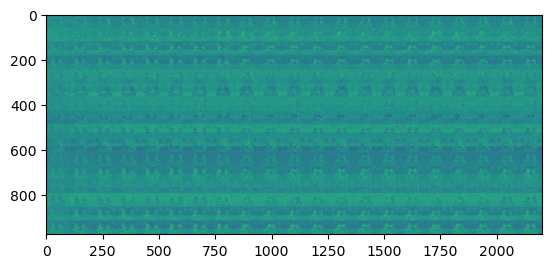

In [58]:
plt.imshow(viz['x_initial_40'])

In [60]:
from pathlib import Path

In [63]:
# save_dir=Path('viz/mar_6_1')
# save_dir.mkdir(exist_ok=True, parents=True)

100%|███████████████████████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.55s/it]


<Figure size 640x480 with 0 Axes>

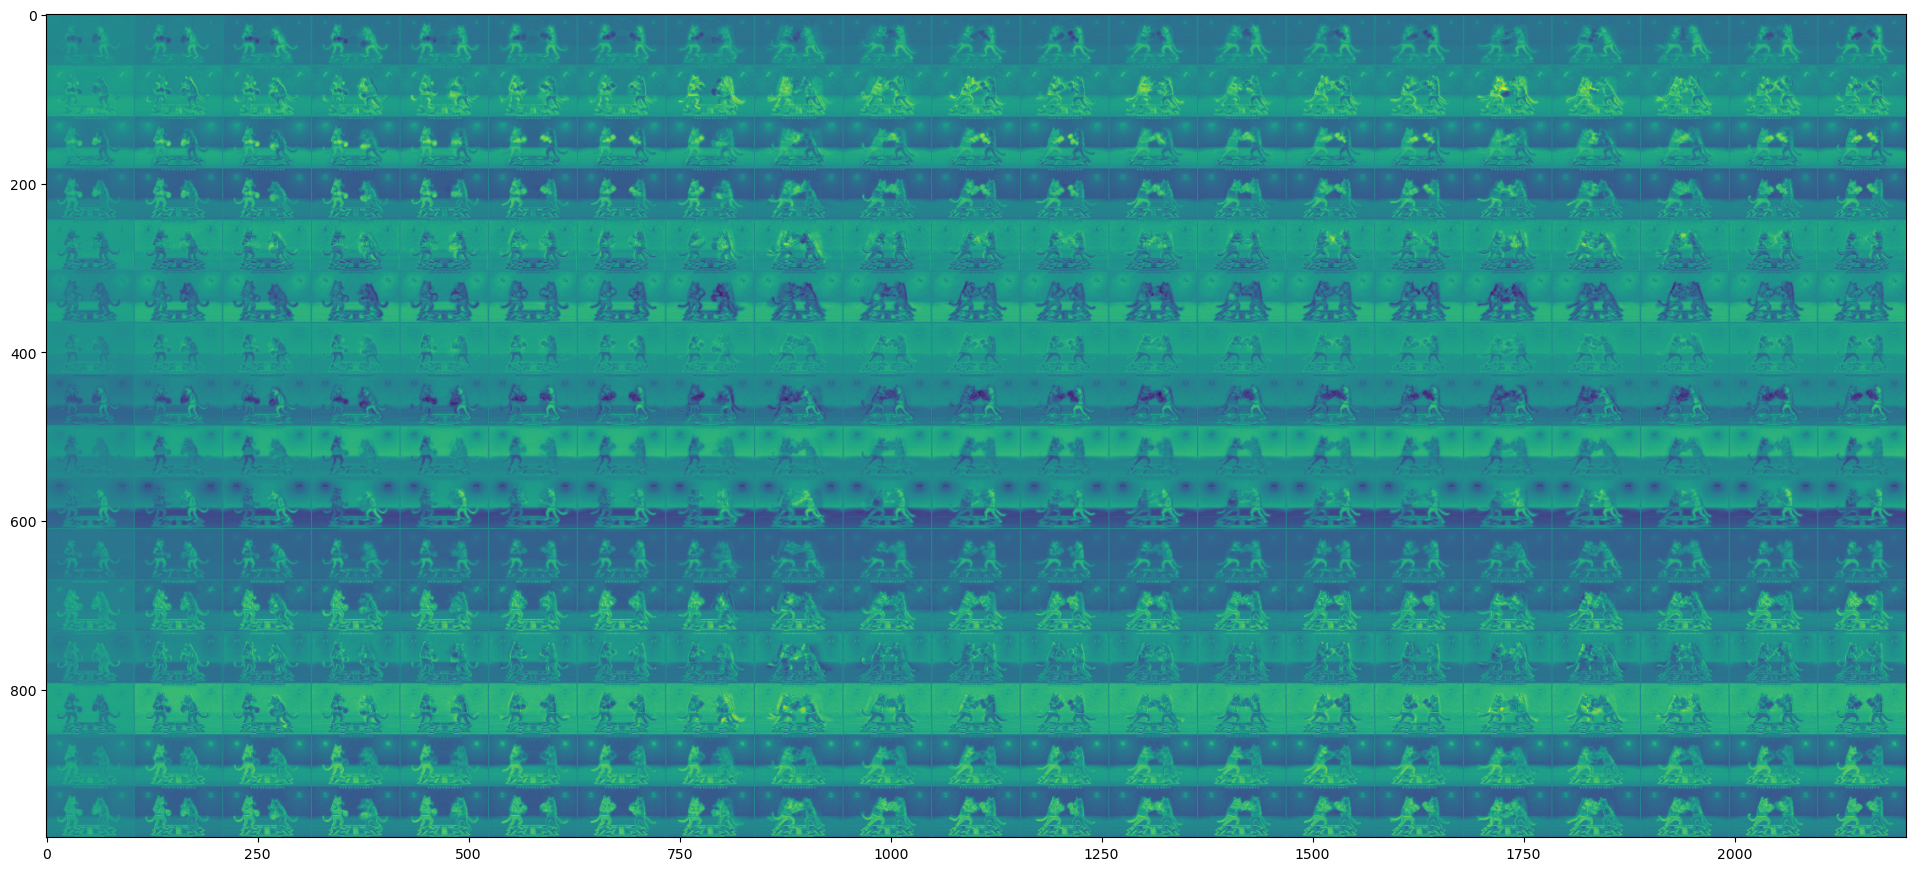

In [65]:
# for v in ['x_initial_', 'noise_pred_cond_', 'noise_pred_uncond', 'noise_pred', 'latents']:
#     (save_dir/v).mkdir(exist_ok=True, parents=True)
#     for i, t in enumerate(tqdm(timesteps)):
#         plt.clf()
#         fig=plt.figure(0, (24,12))
#         plt.imshow(viz[v+str(i)])
#         plt.savefig(save_dir/v/(save_dir.name+'_'+v+'_'+str(i)+'.png'), dpi=100, bbox_inches='tight')

In [66]:
viz['x_patchified_0'].shape

torch.Size([1, 1536, 21, 30, 52])

In [67]:
viz['videos'].shape

torch.Size([3, 81, 480, 832])

In [ ]:
# #Save some viz
# save_dir=Path('viz/feb_9_3')
# save_dir.mkdir(exist_ok=True, parents=True)

# for t in tqdm(['latents', 'noise_predictions_pre_guidance', 'noise_pred', 'old_pred_original_sample']): 
#     (save_dir/t).mkdir(exist_ok=True, parents=True)
#     for i in range(len(viz_cache[t])):
#         plt.clf()
#         image_grid=create_image_grid(viz_cache[t][i][0].detach().cpu().float(), padding=1)
#         fig=plt.figure(0, (12,12))
#         plt.imshow(image_grid)
#         plt.savefig(save_dir/t/(save_dir.name+'_'+t+'_'+str(i)+'.png'), dpi=100)

# # Add video Viz here (1, 81, 480, 720, 3)
# (save_dir/'output_videos').mkdir(exist_ok=True, parents=True)
# for i in range(len(viz_cache['output_videos'])):
#     plt.clf()
#     fig=plt.figure(0, (16,9))
#     for j in range(video.shape[1]):
#         fig.add_subplot(9,9,j+1)
#         plt.imshow(viz_cache['output_videos'][i][0, j])
#     plt.savefig(save_dir/'output_videos'/(save_dir.name+'_output_videos_'+str(i)+'.png'), dpi=100)
        
        
# # rsync -auv stephen@dev-3:/home/stephen/sora/CogVideo/viz .